<a href="https://colab.research.google.com/gist/emfdavid/89516e3f04bd46cf283f27ec0f22eeda/dynamicgribchunking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Zarr Store Demo

Work with NODD GFS data on GCP (theoretically works with AWS as well)

1) Demonstrate building a DataTree, Index File mapping and Static Metdata data file. Use the mapping to rapidly build a on month dataset.
2) Demonstrate using zarr chunk_getitems hack to parallelize getting a timeseries
   

## Import some stuff...

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import importlib

importlib.reload(logging)
logging.basicConfig(
    format="%(asctime)s.%(msecs)03dZ %(processName)s %(threadName)s %(levelname)s:%(name)s:%(message)s",
    datefmt="%Y-%m-%dT%H:%M:%S",
    level=logging.WARNING,
)

logger = logging.getLogger("colab")

In [2]:
import datetime
import copy
import xarray as xr
import numpy as np
import pandas as pd
import fsspec
import kerchunk
from kerchunk.grib2 import scan_grib, grib_tree
import gcsfs
import datatree

# This could be generalized to any gridded FMRC dataset but right now it works with NOAA's Grib2 files
import dynamic_zarr_store


/home/builder/projects/nextgen-dmac/grib_index_aggregation/venv/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


## Extract the zarr store metadata


Pick a file, any file... Must be on GCS so that coords use the same file store as the data vars

In [3]:
# Pick two files to build a grib_tree with the correct dimensions
gfs_files = [
    "gs://global-forecast-system/gfs.20230928/00/atmos/gfs.t00z.pgrb2.0p25.f000",
    "gs://global-forecast-system/gfs.20230928/00/atmos/gfs.t00z.pgrb2.0p25.f001"
]

# This operation reads two of the large Grib2 files from GCS
# scan_grib extracts the zarr kerchunk metadata for each individual grib message
# grib_tree builds a zarr/xarray compatible hierarchical view of the dataset
gfs_grib_tree_store = grib_tree([group for f in gfs_files for group in scan_grib(f)])
# it is slow even in parallel because it requires a huge amount of IO


/home/builder/projects/nextgen-dmac/grib_index_aggregation/venv/lib/python3.10/site-packages/kerchunk/combine.py:370: UserWarning: Concatenated coordinate 'time' contains less than expectednumber of values across the datasets: [1695859200]
  warnings.warn(
/home/builder/projects/nextgen-dmac/grib_index_aggregation/venv/lib/python3.10/site-packages/kerchunk/combine.py:370: UserWarning: Concatenated coordinate 'step' contains less than expectednumber of values across the datasets: [1.]
  warnings.warn(


In [4]:
# The grib_tree can be opened directly using either zarr or xarray datatree
# But this is too slow to build big aggregations
gfs_dt = datatree.open_datatree(fsspec.filesystem("reference", fo=gfs_grib_tree_store).get_mapper(""), engine="zarr", consolidated=False)
gfs_dt


DataTree('None', parent=None)
├── DataTree('4lftx')
│   │   Dimensions:  ()
│   │   Data variables:
│   │       *empty*
│   │   Attributes:
│   │       name:     Best (4-layer) lifted index
│   └── DataTree('instant')
│       │   Dimensions:  ()
│       │   Data variables:
│       │       *empty*
│       │   Attributes:
│       │       stepType:  instant
│       └── DataTree('surface')
│               Dimensions:     (time: 1, step: 2, latitude: 721, longitude: 1440)
│               Coordinates:
│                 * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
│                 * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
│                 * step        (step) timedelta64[ns] 16B 00:00:00 01:00:00
│                   surface     float64 8B ...
│                 * time        (time) datetime64[ns] 8B 2023-09-28
│                   valid_time  (time, step) datetime64[ns] 16B ...
│               Data variables:
│                   4lftx       (time, step, latitude, longitude) float64 17MB ...
│               Attributes:
│                   typeOfLevel:  surface
├── DataTree('SUNSD')
│   │   Dimensions:  ()
│   │   Data variables:
│   │       *empty*
│   │   Attributes:
│   │       name:     Sunshine Duration
│   └── DataTree('instant')
│       │   Dimensions:  ()
│       │   Data variables:
│       │       *empty*
│       │   Attributes:
│       │       stepType:  instant
│       └── DataTree('surface')
│               Dimensions:     (time: 1, step: 2, latitude: 721, longitude: 1440)
│               Coordinates:
│                 * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
│                 * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
│                 * step        (step) timedelta64[ns] 16B 00:00:00 01:00:00
│                   surface     float64 8B ...
│                 * time        (time) datetime64[ns] 8B 2023-09-28
│                   valid_time  (time, step) datetime64[ns] 16B ...
│               Data variables:
│                   SUNSD       (time, step, latitude, longitude) float64 17MB ...
│               Attributes:
│                   typeOfLevel:  surface
├── DataTree('VRATE')
│   │   Dimensions:  ()
│   │   Data variables:
│   │       *empty*
│   │   Attributes:
│   │       name:     Ventilation Rate
│   └── DataTree('instant')
│       │   Dimensions:  ()
│       │   Data variables:
│       │       *empty*
│       │   Attributes:
│       │       stepType:  instant
│       └── DataTree('planetaryBoundaryLayer')
│               Dimensions:                 (time: 1, step: 2, latitude: 721, longitude: 1440)
│               Coordinates:
│                 * latitude                (latitude) float64 6kB 90.0 89.75 ... -89.75 -90.0
│                 * longitude               (longitude) float64 12kB 0.0 0.25 ... 359.5 359.8
│                   planetaryBoundaryLayer  float64 8B ...
│                 * step                    (step) timedelta64[ns] 16B 00:00:00 01:00:00
│                 * time                    (time) datetime64[ns] 8B 2023-09-28
│                   valid_time              (time, step) datetime64[ns] 16B ...
│               Data variables:
│                   VRATE                   (time, step, latitude, longitude) float64 17MB ...
│               Attributes:
│                   typeOfLevel:  planetaryBoundaryLayer
├── DataTree('absv')
│   │   Dimensions:  ()
│   │   Data variables:
│   │       *empty*
│   │   Attributes:
│   │       name:     Absolute vorticity
│   └── DataTree('instant')
│       │   Dimensions:  ()
│       │   Data variables:
│       │       *empty*
│       │   Attributes:
│       │       stepType:  instant
│       ├── DataTree('isobaricInPa')
│       │       Dimensions:       (time: 1, step: 2, isobaricInPa: 8, latitude: 721,
│       │                          longitude: 1440)
│       │       Coordinates:
│       │         * isobaricInPa  (isobaricInPa) f

## Separating static metadata from the chunk indexes

In [6]:
# The key metadata associated with each grib message can be extracted into a table
gfs_kind = dynamic_zarr_store.extract_datatree_chunk_index(gfs_dt, gfs_grib_tree_store, grib=True)
gfs_kind

varname             typeOfLevel stepType                         name  \
0      4lftx                 surface  instant  Best (4-layer) lifted index   
1      4lftx                 surface  instant  Best (4-layer) lifted index   
2      SUNSD                 surface  instant            Sunshine Duration   
3      SUNSD                 surface  instant            Sunshine Duration   
4      VRATE  planetaryBoundaryLayer  instant             Ventilation Rate   
...      ...                     ...      ...                          ...   
1400      wz           isobaricInhPa  instant  Geometric vertical velocity   
1401      wz           isobaricInhPa  instant  Geometric vertical velocity   
1402      wz           isobaricInhPa  instant  Geometric vertical velocity   
1403      wz           isobaricInhPa  instant  Geometric vertical velocity   
1404      wz           isobaricInhPa  instant  Geometric vertical velocity   

                step   level       time          valid_time  \
0    0 days 00:00:00     0.0 2023-09-28 2023-09-28 00:00:00   
1    0 days 01:00:00     0.0 2023-09-28 2023-09-28 01:00:00   
2    0 days 00:00:00     0.0 2023-09-28 2023-09-28 00:00:00   
3    0 days 01:00:00     0.0 2023-09-28 2023-09-28 01:00:00   
4    0 days 00:00:00     0.0 2023-09-28 2023-09-28 00:00:00   
...              ...     ...        ...                 ...   
1400 0 days 01:00:00   900.0 2023-09-28 2023-09-28 01:00:00   
1401 0 days 01:00:00   925.0 2023-09-28 2023-09-28 01:00:00   
1402 0 days 01:00:00   950.0 2023-09-28 2023-09-28 01:00:00   
1403 0 days 01:00:00   975.0 2023-09-28 2023-09-28 01:00:00   
1404 0 days 01:00:00  1000.0 2023-09-28 2023-09-28 01:00:00   

                                                    uri     offset   length  \
0     gs://global-forecast-system/gfs.20230928/00/at...  474813610   515080   
1     gs://global-forecast-system/gfs.20230928/00/at...  507180090   513839   
2     gs://global-forecast-system/gfs.20230928/00/at...  416447304   383061   
3     gs://global-forecast-system/gfs.20230928/00/at...  429168740   221940   
4     gs://global-forecast-system/gfs.20230928/00/at...    6054405   591959   
...                                                 ...        ...      ...   
1400  gs://global-forecast-system/gfs.20230928/00/at...  349016299  1153904   
1401  gs://global-forecast-system/gfs.20230928/00/at...  361143359  1137808   
1402  gs://global-forecast-system/gfs.20230928/00/at...  373027803  1105352   
1403  gs://global-forecast-system/gfs.20230928/00/at...  384543278  1033901   
1404  gs://global-forecast-system/gfs.20230928/00/at...  394297534   905395   

     inline_value  
0            None  
1            None  
2            None  
3            None  
4            None  
...           ...  
1400         None  
1401         None  
1402         None  
1403         None  
1404         None  

[1405 rows x 12 columns]

In [7]:
# While the static zarr metadata associated with the dataset can be seperated - created once.
deflated_gfs_grib_tree_store = copy.deepcopy(gfs_grib_tree_store)
dynamic_zarr_store.strip_datavar_chunks(deflated_gfs_grib_tree_store)


print("Original references: ", len(gfs_grib_tree_store["refs"]))
print("Stripped references: ", len(deflated_gfs_grib_tree_store["refs"]))


Original references:  7092
Stripped references:  3739


## Building it faster

Okay that was fun - I promise you can recombine these pieces but it still takes the same amount of time to run scan_grib.

The k(erchunk) index data looks a lot like the idx files that are present for every grib file in NODD's GCS archive though...


```
1:0:d=2023092800:PRMSL:mean sea level:1 hour fcst:
2:990253:d=2023092800:CLWMR:1 hybrid level:1 hour fcst:
3:1079774:d=2023092800:ICMR:1 hybrid level:1 hour fcst:
4:1332540:d=2023092800:RWMR:1 hybrid level:1 hour fcst:
5:1558027:d=2023092800:SNMR:1 hybrid level:1 hour fcst:
6:1638489:d=2023092800:GRLE:1 hybrid level:1 hour fcst:
7:1673516:d=2023092800:REFD:1 hybrid level:1 hour fcst:
8:2471710:d=2023092800:REFD:2 hybrid level:1 hour fcst:
9:3270627:d=2023092800:REFC:entire atmosphere:1 hour fcst:
10:4144435:d=2023092800:VIS:surface:1 hour fcst:
```

But the metadata isn't quiet the same... they have mangled the attributes in the : seperated attributes.

In [8]:
# We can pull this out into a dataframe, that starts to look a bit like what we got above extracted from the actual grib files
# But this method runs in under a second reading a file that is less than 100k
idxdf = dynamic_zarr_store.parse_grib_idx(
    fs=fsspec.filesystem("gcs"),
    basename="gs://global-forecast-system/gfs.20230901/00/atmos/gfs.t00z.pgrb2.0p25.f006"
)
idxdf

offset          date  \
idx                            
1            0  d=2023090100   
2       877361  d=2023090100   
3       968114  d=2023090100   
4      1196150  d=2023090100   
5      1462913  d=2023090100   
..         ...           ...   
739  524888345  d=2023090100   
740  525549222  d=2023090100   
741  526206079  d=2023090100   
742  527391920  d=2023090100   
743  528541061  d=2023090100   

                                                 attrs   length  \
idx                                                               
1                  PRMSL:mean sea level:6 hour fcst:\n   877361   
2                  CLWMR:1 hybrid level:6 hour fcst:\n    90753   
3                   ICMR:1 hybrid level:6 hour fcst:\n   228036   
4                   RWMR:1 hybrid level:6 hour fcst:\n   266763   
5                   SNMR:1 hybrid level:6 hour fcst:\n    81052   
..                                                 ...      ...   
739  VGRD:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:\n   660877   
740   TMP:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:\n   656857   
741   HGT:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:\n  1185841   
742  PRES:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:\n  1149141   
743  VWSH:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:\n   505888   

                                               idx_uri  \
idx                                                      
1    gs://global-forecast-system/gfs.20230901/00/at...   
2    gs://global-forecast-system/gfs.20230901/00/at...   
3    gs://global-forecast-system/gfs.20230901/00/at...   
4    gs://global-forecast-system/gfs.20230901/00/at...   
5    gs://global-forecast-system/gfs.20230901/00/at...   
..                                                 ...   
739  gs://global-forecast-system/gfs.20230901/00/at...   
740  gs://global-forecast-system/gfs.20230901/00/at...   
741  gs://global-forecast-system/gfs.20230901/00/at...   
742  gs://global-forecast-system/gfs.20230901/00/at...   
743  gs://global-forecast-system/gfs.20230901/00/at...   

                                              grib_uri  \
idx                                                      
1    gs://global-forecast-system/gfs.20230901/00/at...   
2    gs://global-forecast-system/gfs.20230901/00/at...   
3    gs://global-forecast-system/gfs.20230901/00/at...   
4    gs://global-forecast-system/gfs.20230901/00/at...   
5    gs://global-forecast-system/gfs.20230901/00/at...   
..                                                 ...   
739  gs://global-forecast-system/gfs.20230901/00/at...   
740  gs://global-forecast-system/gfs.20230901/00/at...   
741  gs://global-forecast-system/gfs.20230901/00/at...   
742  gs://global-forecast-system/gfs.20230901/00/at...   
743  gs://global-forecast-system/gfs.20230901/00/at...   

                    indexed_at grib_crc32         grib_updated_at idx_crc32  \
idx                                                                           
1   2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
2   2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
3   2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
4   2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
5   2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
..                         ...        ...                     ...       ...   
739 2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
740 2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
741 2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
742 2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
743 2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   

             idx_updated_at  
idx                          
1   2023-09-01 03:34:44.443  
2   2023-09-01 03:34:44.443  
3   2023-09-01 03:34:44.443  
4   2023-09-01 03:34:44.443  
5

In [9]:
# Unfortunately, some accumulation variables have duplicate attributes making them
# indesinguishable from the IDX file
idxdf.loc[idxdf['attrs'].duplicated(keep=False), :]


offset          date                               attrs  length  \
idx                                                                        
596  422992587  d=2023090100   APCP:surface:0-6 hour acc fcst:\n  368264   
597  423360851  d=2023090100   APCP:surface:0-6 hour acc fcst:\n  368264   
598  423729115  d=2023090100  ACPCP:surface:0-6 hour acc fcst:\n  282099   
599  424011214  d=2023090100  ACPCP:surface:0-6 hour acc fcst:\n  282099   

                                               idx_uri  \
idx                                                      
596  gs://global-forecast-system/gfs.20230901/00/at...   
597  gs://global-forecast-system/gfs.20230901/00/at...   
598  gs://global-forecast-system/gfs.20230901/00/at...   
599  gs://global-forecast-system/gfs.20230901/00/at...   

                                              grib_uri  \
idx                                                      
596  gs://global-forecast-system/gfs.20230901/00/at...   
597  gs://global-forecast-system/gfs.20230901/00/at...   
598  gs://global-forecast-system/gfs.20230901/00/at...   
599  gs://global-forecast-system/gfs.20230901/00/at...   

                    indexed_at grib_crc32         grib_updated_at idx_crc32  \
idx                                                                           
596 2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
597 2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
598 2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
599 2024-03-06 00:18:06.853087   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   

             idx_updated_at  
idx                          
596 2023-09-01 03:34:44.443  
597 2023-09-01 03:34:44.443  
598 2023-09-01 03:34:44.443  
599 2023-09-01 03:34:44.443

In [10]:
# What we need is a mapping from our grib/zarr metadata to the attributes in the idx files
# They are unique for each time horizon e.g. you need to build a unique mapping for the 1 hour
# forecast, the 2 hour forecast... the 48 hour forecast.

# let's make one for the 6 hour horizon. This requires reading both the grib and the idx file,
# mapping the data for each grib message in order
mapping = dynamic_zarr_store.build_idx_grib_mapping(
    fs=fsspec.filesystem("gcs"),
    basename="gs://global-forecast-system/gfs.20230928/00/atmos/gfs.t00z.pgrb2.0p25.f006",
)
mapping

2024-03-06T00:20:28.260Z MainProcess MainThread WARNING:dynamic_zarr_store:The idx attribute mapping for gs://global-forecast-system/gfs.20230928/00/atmos/gfs.t00z.pgrb2.0p25.f006 is not unique for 4 variables: ['tp', 'tp', 'acpcp', 'acpcp']
2024-03-06T00:20:28.269Z MainProcess MainThread WARNING:dynamic_zarr_store:The grib hierarchy in gs://global-forecast-system/gfs.20230928/00/atmos/gfs.t00z.pgrb2.0p25.f006 is not unique for 26 variables: ['st', 'soilw', 'soill', 'st', 'soilw', 'soill', 'st', 'soilw', 'soill', 'st', 'soilw', 'soill', 'tp', 'tp', 'acpcp', 'acpcp', 'cape', 'cin', 'r', 'r', 'r', 'r', 'cape', 'cin', 'cape', 'cin']


offset_idx          date  \
idx                             
1             0  d=2023092800   
2        984804  d=2023092800   
3       1070431  d=2023092800   
4       1314876  d=2023092800   
5       1551504  d=2023092800   
..          ...           ...   
739   535590536  d=2023092800   
740   536236809  d=2023092800   
741   536887172  d=2023092800   
742   538061812  d=2023092800   
743   539196945  d=2023092800   

                                                 attrs  length_idx  \
idx                                                                  
1                  PRMSL:mean sea level:6 hour fcst:\n      984804   
2                  CLWMR:1 hybrid level:6 hour fcst:\n       85627   
3                   ICMR:1 hybrid level:6 hour fcst:\n      244445   
4                   RWMR:1 hybrid level:6 hour fcst:\n      236628   
5                   SNMR:1 hybrid level:6 hour fcst:\n       78043   
..                                                 ...         ...   
739  VGRD:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:\n      646273   
740   TMP:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:\n      650363   
741   HGT:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:\n     1174640   
742  PRES:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:\n     1135133   
743  VWSH:PV=-2e-06 (Km^2/kg/s) surface:6 hour fcst:\n      499482   

                                               idx_uri  \
idx                                                      
1    gs://global-forecast-system/gfs.20230928/00/at...   
2    gs://global-forecast-system/gfs.20230928/00/at...   
3    gs://global-forecast-system/gfs.20230928/00/at...   
4    gs://global-forecast-system/gfs.20230928/00/at...   
5    gs://global-forecast-system/gfs.20230928/00/at...   
..                                                 ...   
739  gs://global-forecast-system/gfs.20230928/00/at...   
740  gs://global-forecast-system/gfs.20230928/00/at...   
741  gs://global-forecast-system/gfs.20230928/00/at...   
742  gs://global-forecast-system/gfs.20230928/00/at...   
743  gs://global-forecast-system/gfs.20230928/00/at...   

                                              grib_uri  \
idx                                                      
1    gs://global-forecast-system/gfs.20230928/00/at...   
2    gs://global-forecast-system/gfs.20230928/00/at...   
3    gs://global-forecast-system/gfs.20230928/00/at...   
4    gs://global-forecast-system/gfs.20230928/00/at...   
5    gs://global-forecast-system/gfs.20230928/00/at...   
..                                                 ...   
739  gs://global-forecast-system/gfs.20230928/00/at...   
740  gs://global-forecast-system/gfs.20230928/00/at...   
741  gs://global-forecast-system/gfs.20230928/00/at...   
742  gs://global-forecast-system/gfs.20230928/00/at...   
743  gs://global-forecast-system/gfs.20230928/00/at...   

                    indexed_at grib_crc32         grib_updated_at idx_crc32  \
idx                                                                           
1   2024-03-06 00:20:28.222462   AzsvRA== 2023-09-28 03:35:01.964  k5v7JQ==   
2   2024-03-06 00:20:28.222462   AzsvRA== 2023-09-28 03:35:01.964  k5v7JQ==   
3   2024-03-06 00:20:28.222462   AzsvRA== 2023-09-28 03:35:01.964  k5v7JQ==   
4   2024-03-06 00:20:28.222462   AzsvRA== 2023-09-28 03:35:01.964  k5v7JQ==   
5   2024-03-06 00:20:28.222462   AzsvRA== 2023-09-28 03:35:01.964  k5v7JQ==   
..                         ...        ...                     ...       ...   
739 2024-03-06 00:20:28.222462   AzsvRA== 2023-09-28 03:35:01.964  k5v7JQ==   
740 2024-03-06 00:20:28.222462   AzsvRA== 2023-09-28 03:35:01.964  k5v7JQ==   
741 2024-03-06 00:20:28.222462   AzsvRA== 2023-09-28 03:35:01.964  k5v7JQ==   
742 2024-03-06 00:20:28.222462   AzsvRA== 2023-09-28 03:35:01.964  k5v7JQ==   
743 2024-03-06 00:20:28.222462   AzsvRA== 2023-09-28 03:35:01.964  k5v7JQ==   

     ... stepType                     name      level            step  \
idx  ...                                             

In [11]:
# Now if we parse the RunTime from the idx file name `gfs.20230901/00/`
# We can build a fully compatible k_index
mapped_index = dynamic_zarr_store.map_from_index(
    pd.Timestamp("2023-09-01T00"),
    mapping.loc[~mapping["attrs"].duplicated(keep="first"), :],
    idxdf.loc[~idxdf["attrs"].duplicated(keep="first"), :]
)
mapped_index

varname         typeOfLevel stepType                     name  \
0     prmsl             meanSea  instant  Pressure reduced to MSL   
1     clwmr              hybrid  instant       Cloud mixing ratio   
2      icmr              hybrid  instant   Ice water mixing ratio   
3      rwmr              hybrid  instant        Rain mixing ratio   
4      snmr              hybrid  instant        Snow mixing ratio   
..      ...                 ...      ...                      ...   
736       v  potentialVorticity  instant      V component of wind   
737       t  potentialVorticity  instant              Temperature   
738      gh  potentialVorticity  instant      Geopotential Height   
739    pres  potentialVorticity  instant                 Pressure   
740    vwsh  potentialVorticity  instant     Vertical speed shear   

               step      level       time          valid_time  \
0   0 days 06:00:00        0.0 2023-09-01 2023-09-01 06:00:00   
1   0 days 06:00:00        1.0 2023-09-01 2023-09-01 06:00:00   
2   0 days 06:00:00        1.0 2023-09-01 2023-09-01 06:00:00   
3   0 days 06:00:00        1.0 2023-09-01 2023-09-01 06:00:00   
4   0 days 06:00:00        1.0 2023-09-01 2023-09-01 06:00:00   
..              ...        ...        ...                 ...   
736 0 days 06:00:00  2147486.0 2023-09-01 2023-09-01 06:00:00   
737 0 days 06:00:00  2147486.0 2023-09-01 2023-09-01 06:00:00   
738 0 days 06:00:00  2147486.0 2023-09-01 2023-09-01 06:00:00   
739 0 days 06:00:00  2147486.0 2023-09-01 2023-09-01 06:00:00   
740 0 days 06:00:00  2147486.0 2023-09-01 2023-09-01 06:00:00   

                                                   uri     offset   length  \
0    gs://global-forecast-system/gfs.20230901/00/at...          0   877361   
1    gs://global-forecast-system/gfs.20230901/00/at...     877361    90753   
2    gs://global-forecast-system/gfs.20230901/00/at...     968114   228036   
3    gs://global-forecast-system/gfs.20230901/00/at...    1196150   266763   
4    gs://global-forecast-system/gfs.20230901/00/at...    1462913    81052   
..                                                 ...        ...      ...   
736  gs://global-forecast-system/gfs.20230901/00/at...  524888345   660877   
737  gs://global-forecast-system/gfs.20230901/00/at...  525549222   656857   
738  gs://global-forecast-system/gfs.20230901/00/at...  526206079  1185841   
739  gs://global-forecast-system/gfs.20230901/00/at...  527391920  1149141   
740  gs://global-forecast-system/gfs.20230901/00/at...  528541061   505888   

    inline_value grib_crc32         grib_updated_at idx_crc32  \
0           None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
1           None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
2           None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
3           None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
4           None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
..           ...        ...                     ...       ...   
736         None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
737         None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
738         None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
739         None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
740         None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   

             idx_updated_at                 indexed_at  
0   2023-09-01 03:34:44.443 2024-03-06 00:18:06.853087  
1   2023-09-01 03:34:44.443 2024-03-06 00:18:06.853087  
2   2023-09-01 03:34:44.443 2024-03-06 00:18:06.853087  
3   2023-09-01 03:34:44.443 2024-03-06 00:18:06.853087  
4   2023-09-01 03:34:44.443 2024-03-06 00:18:06.853087  
..                      ...                        ...  
736 2023-09-01 03:34:44.443 2024-03-06 00:18:06.853087  
737 2023-09-01 03:34:44.443 2024-03-06 00:18:06.853087  
738 2023-09-01 03:34:44.443 2024-03-06 00:18:06.853087  
739 2023-09-01 03:34:44.443 2024-03-06 00:18:06.853087  
740 2023-09-01 03:34:44.443 2024-03-06 00:18:06.8

In [12]:
mapped_index_list = []

deduped_mapping = mapping.loc[~mapping["attrs"].duplicated(keep="first"), :]
for date in pd.date_range("2023-09-01", "2023-09-30"):
  for runtime in range(0,24,6):
    horizon=6
    fname=f"gs://global-forecast-system/gfs.{date.strftime('%Y%m%d')}/{runtime:02}/atmos/gfs.t{runtime:02}z.pgrb2.0p25.f{horizon:03}"

    idxdf = dynamic_zarr_store.parse_grib_idx(
        fs=fsspec.filesystem("gcs"),
        basename=fname
    )

    mapped_index = dynamic_zarr_store.map_from_index(
        pd.Timestamp( date + datetime.timedelta(hours=runtime)),
        deduped_mapping,
        idxdf.loc[~idxdf["attrs"].duplicated(keep="first"), :],
    )
    mapped_index_list.append(mapped_index)

gfs_kind = pd.concat(mapped_index_list)
gfs_kind


varname         typeOfLevel stepType                     name  \
0     prmsl             meanSea  instant  Pressure reduced to MSL   
1     clwmr              hybrid  instant       Cloud mixing ratio   
2      icmr              hybrid  instant   Ice water mixing ratio   
3      rwmr              hybrid  instant        Rain mixing ratio   
4      snmr              hybrid  instant        Snow mixing ratio   
..      ...                 ...      ...                      ...   
736       v  potentialVorticity  instant      V component of wind   
737       t  potentialVorticity  instant              Temperature   
738      gh  potentialVorticity  instant      Geopotential Height   
739    pres  potentialVorticity  instant                 Pressure   
740    vwsh  potentialVorticity  instant     Vertical speed shear   

               step      level                time          valid_time  \
0   0 days 06:00:00        0.0 2023-09-01 00:00:00 2023-09-01 06:00:00   
1   0 days 06:00:00        1.0 2023-09-01 00:00:00 2023-09-01 06:00:00   
2   0 days 06:00:00        1.0 2023-09-01 00:00:00 2023-09-01 06:00:00   
3   0 days 06:00:00        1.0 2023-09-01 00:00:00 2023-09-01 06:00:00   
4   0 days 06:00:00        1.0 2023-09-01 00:00:00 2023-09-01 06:00:00   
..              ...        ...                 ...                 ...   
736 0 days 06:00:00  2147486.0 2023-09-30 18:00:00 2023-10-01 00:00:00   
737 0 days 06:00:00  2147486.0 2023-09-30 18:00:00 2023-10-01 00:00:00   
738 0 days 06:00:00  2147486.0 2023-09-30 18:00:00 2023-10-01 00:00:00   
739 0 days 06:00:00  2147486.0 2023-09-30 18:00:00 2023-10-01 00:00:00   
740 0 days 06:00:00  2147486.0 2023-09-30 18:00:00 2023-10-01 00:00:00   

                                                   uri     offset   length  \
0    gs://global-forecast-system/gfs.20230901/00/at...          0   877361   
1    gs://global-forecast-system/gfs.20230901/00/at...     877361    90753   
2    gs://global-forecast-system/gfs.20230901/00/at...     968114   228036   
3    gs://global-forecast-system/gfs.20230901/00/at...    1196150   266763   
4    gs://global-forecast-system/gfs.20230901/00/at...    1462913    81052   
..                                                 ...        ...      ...   
736  gs://global-forecast-system/gfs.20230930/18/at...  535413574   651311   
737  gs://global-forecast-system/gfs.20230930/18/at...  536064885   651260   
738  gs://global-forecast-system/gfs.20230930/18/at...  536716145  1175436   
739  gs://global-forecast-system/gfs.20230930/18/at...  537891581  1135959   
740  gs://global-forecast-system/gfs.20230930/18/at...  539027540   498795   

    inline_value grib_crc32         grib_updated_at idx_crc32  \
0           None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
1           None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
2           None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
3           None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
4           None   0f2Mww== 2023-09-01 03:36:52.570  ZmkdeQ==   
..           ...        ...                     ...       ...   
736         None   AxWcLQ== 2023-09-30 21:35:37.944  VIpnnw==   
737         None   AxWcLQ== 2023-09-30 21:35:37.944  VIpnnw==   
738         None   AxWcLQ== 2023-09-30 21:35:37.944  VIpnnw==   
739         None   AxWcLQ== 2023-09-30 21:35:37.944  VIpnnw==   
740         None   AxWcLQ== 2023-09-30 21:35:37.944  VIpnnw==   

             idx_updated_at                 indexed_at  
0   2023-09-01 03:34:44.443 2024-03-06 00:21:25.869038  
1   2023-09-01 03:34:44.443 2024-03-06 00:21:25.869038  
2   2023-09-01 03:34:44.443 2024-03-06 00:21:25.869038  
3   2023-09-01 03:34:44.443 2024-03-06 00:21:25.869038  
4   2023-09-01 03:34:44.443 2024-03-06 00:21:25.869038  
..                      ...                        ...  
736 2023-09-30 21:34:36.675 2024-03-06 00:21:55.591651  
737 2023-09-30 21:34:36.675 2024-03-06 00:21:55.591651  
738 2023-09-30 21:34:36.675 2024-03-06 00:21:55.591651 

## We just aggregated a 120 GFS grib files in 18 seconds!

Lets build it back into a data tree!

The reinflate_grib_store interface is pretty opaque but allows building any slice of an FMRC. A good area for future improvement, but for now, since
we have just a single 6 hour horizon slice let's build that...

In [13]:
axes = [
  pd.Index(
    [
      pd.timedelta_range(start="0 hours", end="6 hours", freq="6h", closed="right", name="6 hour"),
    ],
    name="step"
  ),
  pd.date_range("2023-09-01T06:00", "2023-10T00:00", freq="360min", name="valid_time")
]
axes

[Index([[0 days 06:00:00]], dtype='object', name='step'),
 DatetimeIndex(['2023-09-01 06:00:00', '2023-09-01 12:00:00',
                '2023-09-01 18:00:00', '2023-09-02 00:00:00',
                '2023-09-02 06:00:00', '2023-09-02 12:00:00',
                '2023-09-02 18:00:00', '2023-09-03 00:00:00',
                '2023-09-03 06:00:00', '2023-09-03 12:00:00',
                ...
                '2023-09-28 18:00:00', '2023-09-29 00:00:00',
                '2023-09-29 06:00:00', '2023-09-29 12:00:00',
                '2023-09-29 18:00:00', '2023-09-30 00:00:00',
                '2023-09-30 06:00:00', '2023-09-30 12:00:00',
                '2023-09-30 18:00:00', '2023-10-01 00:00:00'],
               dtype='datetime64[ns]', name='valid_time', length=120, freq='360min')]

In [14]:
# It is fast to rebuild the datatree - but lets pull out two varables to look at...
gfs_store = dynamic_zarr_store.reinflate_grib_store(
    axes=axes,
    aggregation_type=dynamic_zarr_store.AggregationType.HORIZON,
    chunk_index=gfs_kind.loc[gfs_kind.varname.isin(["dswrf", "t2m"])],
    zarr_ref_store=deflated_gfs_grib_tree_store
)

/home/builder/projects/nextgen-dmac/grib_index_aggregation/dynamic_zarr_store.py:307: PerformanceWarning: indexing past lexsort depth may impact performance.
  if lookup not in unique_groups:


In [15]:
gfs_dt = datatree.open_datatree(fsspec.filesystem("reference", fo=gfs_store).get_mapper(""), engine="zarr", consolidated=False)
gfs_dt

DataTree('None', parent=None)
├── DataTree('dswrf')
│   │   Dimensions:  ()
│   │   Data variables:
│   │       *empty*
│   │   Attributes:
│   │       name:     Downward short-wave radiation flux
│   └── DataTree('avg')
│       │   Dimensions:  ()
│       │   Data variables:
│       │       *empty*
│       │   Attributes:
│       │       stepType:  avg
│       └── DataTree('surface')
│               Dimensions:     (model_horizons: 1, valid_times: 120, latitude: 721,
│                                longitude: 1440)
│               Coordinates:
│                 * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
│                 * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
│                   step        (model_horizons, valid_times) timedelta64[ns] 960B ...
│                   surface     float64 8B ...
│                   time        (model_horizons, valid_times) datetime64[ns] 960B ...
│                   valid_time  (model_horizons, valid_times) datetime64[ns] 960B ...
│               Dimensions without coordinates: model_horizons, valid_times
│               Data variables:
│                   dswrf       (model_horizons, valid_times, latitude, longitude) float64 997MB ...
│               Attributes:
│                   typeOfLevel:  surface
└── DataTree('t2m')
    │   Dimensions:  ()
    │   Data variables:
    │       *empty*
    │   Attributes:
    │       name:     2 metre temperature
    └── DataTree('instant')
        │   Dimensions:  ()
        │   Data variables:
        │       *empty*
        │   Attributes:
        │       stepType:  instant
        └── DataTree('heightAboveGround')
                Dimensions:            (latitude: 721, longitude: 1440, model_horizons: 1,
                                        valid_times: 120)
                Coordinates:
                    heightAboveGround  float64 8B ...
                  * latitude           (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
                  * longitude          (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
                    step               (model_horizons, valid_times) timedelta64[ns] 960B ...
                    time               (model_horizons, valid_times) datetime64[ns] 960B ...
                    valid_time         (model_horizons, valid_times) datetime64[ns] 960B ...
                Dimensions without coordinates: model_horizons, valid_times
                Data variables:
                    t2m                (model_horizons, valid_times, latitude, longitude) float64 997MB ...
                Attributes:
                    typeOfLevel:  heightAboveGround

In [16]:
# Reading the data - especially extracting point time series isn't any faster once you have
# the xarray datatree. This is just a much faster way of building the aggregations than
# directly running scan_grib over all the data first.
gfs_dt.dswrf.avg.surface.dswrf[0,0:10,300,400].compute()

<xarray.DataArray 'dswrf' (valid_times: 10)> Size: 80B
array([6.52080e+02, 4.14576e+02, 0.00000e+00, 4.48000e-01, 3.99360e+02,
       2.66720e+02, 0.00000e+00, 7.21600e+00, 6.91776e+02, 2.64752e+02])
Coordinates:
    latitude    float64 8B 15.0
    longitude   float64 8B 100.0
    step        (valid_times) timedelta64[ns] 80B 06:00:00 06:00:00 ... 06:00:00
    surface     float64 8B 0.0
    time        (valid_times) datetime64[ns] 80B 2023-09-01 ... 2023-09-03T06...
    valid_time  (valid_times) datetime64[ns] 80B 2023-09-01T06:00:00 ... 2023...
Dimensions without coordinates: valid_times
Attributes: (12/29)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           unknown
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_stepUnits:                           1
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               W m**-2
    long_name:                                Downward short-wave radiation flux
    standard_name:                            unknown
    units:                                    W m**-2

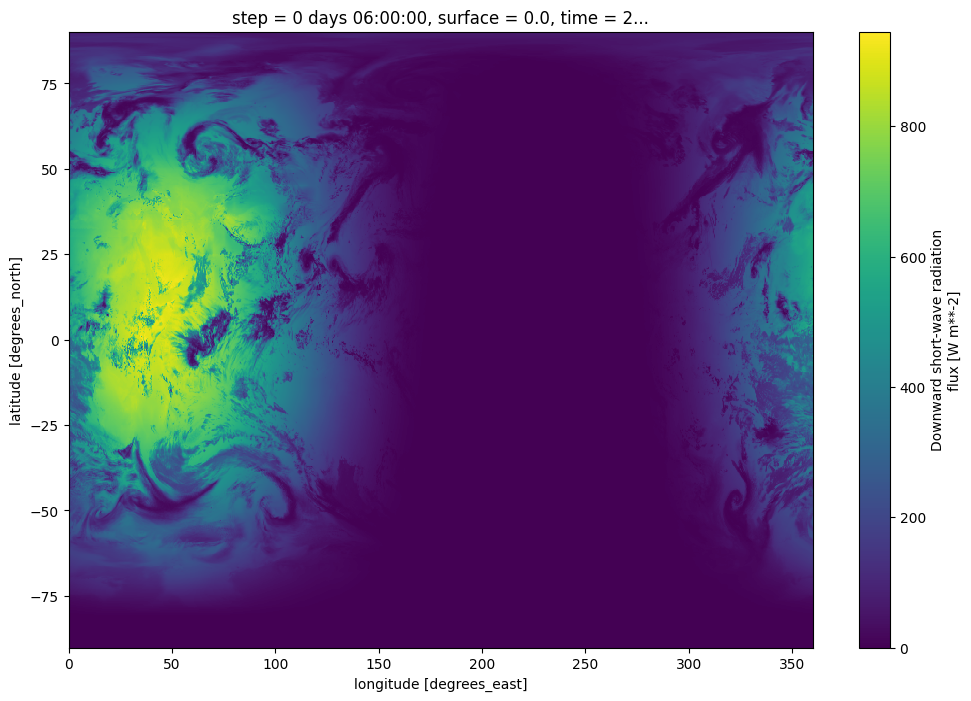

In [18]:
gfs_dt.dswrf.avg.surface.dswrf[0,1,:,:].plot(figsize=(12,8))

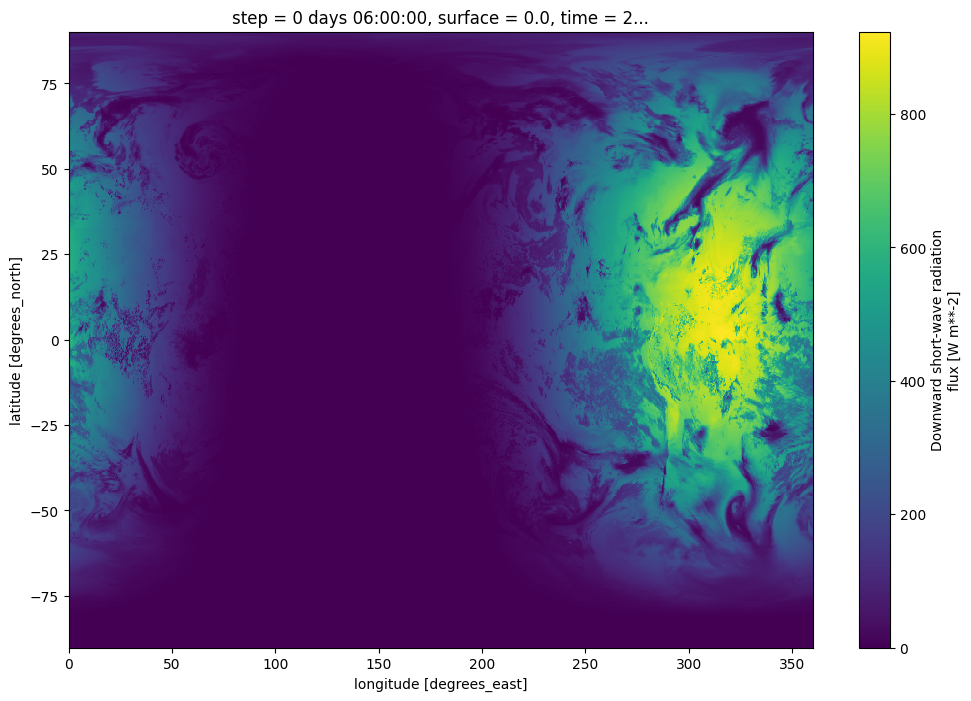

In [19]:
gfs_dt.dswrf.avg.surface.dswrf[0,2,:,:].plot(figsize=(12,8))

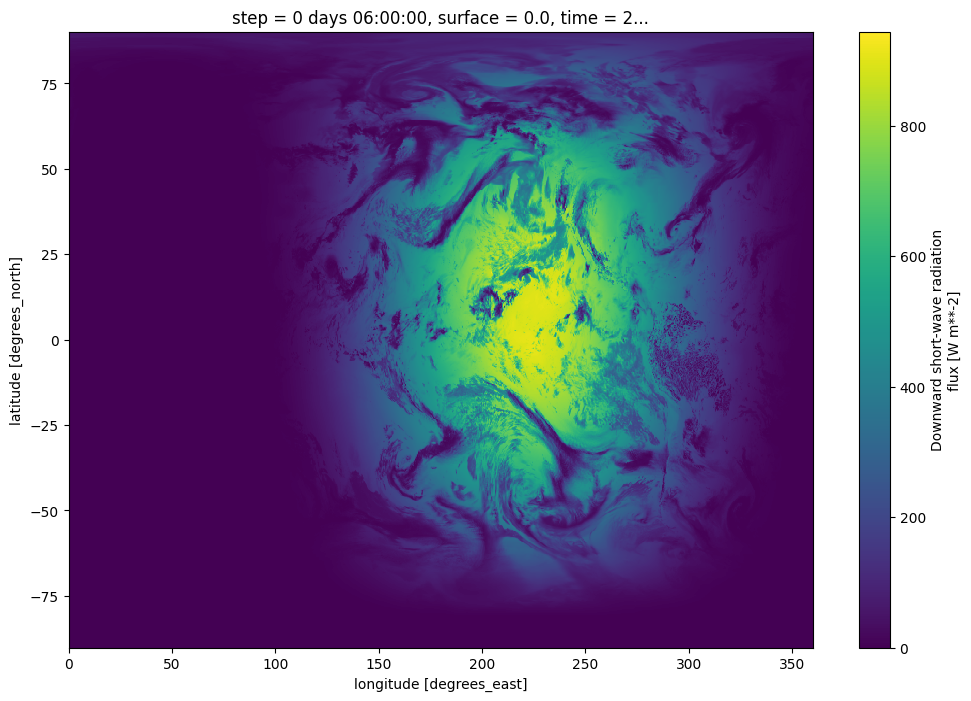

In [20]:
gfs_dt.dswrf.avg.surface.dswrf[0,3,:,:].plot(figsize=(12,8))

# Timeseries

In [22]:
from joblib import parallel_config

In [30]:
with parallel_config(n_jobs=8):
    #res = gfs_dt.dswrf.avg.surface.dswrf.interp(longitude=[320.5, 300.2], latitude=[20.6, 45.7], method="linear")
    res = gfs_dt.dswrf.avg.surface.dswrf.interp(longitude=[320.5], latitude=[20.6], method="linear")


2024-03-06T00:32:56.794Z MainProcess MainThread WARNING:zarr.core:Creating memmap array of shape (1, 120, 4, 4), size 15360 - this could oom or exceed the size of /dev/shm


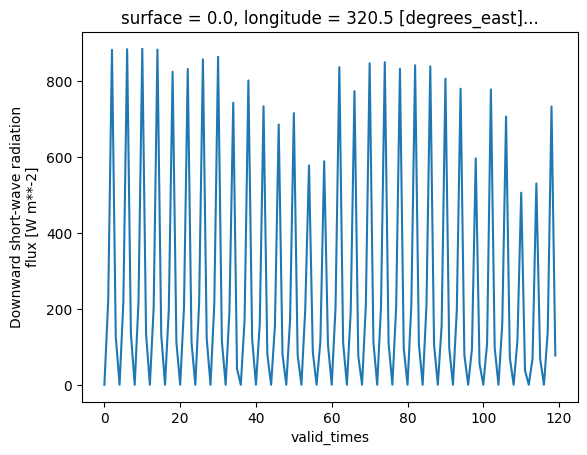

In [31]:
res.plot()
